In [25]:
from Refrig2DrumHeatExConstrDummy import Refrig2DrumConstraintHeatExConstDummy
import os, sys
# Get the parent directory
import os, sys

# Get the absolute path of the notebook's directory
notebook_dir = os.getcwd()

# Navigate to the parent directory
parent_dir = os.path.abspath(os.path.join(notebook_dir, ".."))

# Add the parent directory to sys.path so we can import modules
sys.path.append(parent_dir)

# Verify the path
print(f"Added to sys.path: {parent_dir}")

# Add it to sys.path
sys.path.append(parent_dir)

from grad_ import gradMoment

Added to sys.path: /Users/panwapromtep/Library/CloudStorage/OneDrive-JohnsHopkins/Process Design/Aspen


In [26]:
import numpy as np
flash_1_range = np.linspace(-1000, 1000, 200)
flash_2_range = np.linspace(-1000, 1000, 200)

assSim = Refrig2DrumConstraintHeatExConstDummy(AspenFile = "./FlashOperation/FlashOperation.bkp", 
                                   wdpath = "./FlashOperation", 
                                   visibility=False,
                                   Penalty=1e4
                                   )


⚠️ Dummy Mode: Skipping Aspen simulation initialization.


In [27]:
data = []
for flash_1 in flash_1_range:
    for flash_2 in flash_2_range:
        x_unflat = assSim.unflatten_params([flash_1, flash_2])
        data.append([flash_1, flash_2, assSim.run_obj(x_unflat)])

In [28]:
# Save the data as a numpy array
data = np.array(data)
np.save("data.npy", data)
print("Data saved!")

Data saved!


In [29]:
# Read the data
data = np.load("data.npy")
print(data)

[[-1.00000000e+03 -1.00000000e+03  2.00000000e+06]
 [-1.00000000e+03 -9.89949749e+02  1.98000051e+06]
 [-1.00000000e+03 -9.79899497e+02  1.96020303e+06]
 ...
 [ 1.00000000e+03  9.79899497e+02  1.96020303e+06]
 [ 1.00000000e+03  9.89949749e+02  1.98000051e+06]
 [ 1.00000000e+03  1.00000000e+03  2.00000000e+06]]


In [30]:
## neural network with 3 hidden layers 10 neurons each using torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Write the neural network class with batch normalization and GELU activation
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 10)  # input layer to first hidden layer
        self.bn1 = nn.BatchNorm1d(10)  # batch normalization after first hidden layer
        self.fc2 = nn.Linear(10, 10) # first hidden layer to second hidden layer
        self.bn2 = nn.BatchNorm1d(10)  # batch normalization after second hidden layer
        self.fc3 = nn.Linear(10, 10) # second hidden layer to third hidden layer
        self.bn3 = nn.BatchNorm1d(10)  # batch normalization after third hidden layer
        self.fc4 = nn.Linear(10, 1)  # third hidden layer to output layer

    def forward(self, x):
        x = F.gelu(self.bn1(self.fc1(x)))
        x = F.gelu(self.bn2(self.fc2(x)))
        x = F.gelu(self.bn3(self.fc3(x)))
        x = self.fc4(x)
        return x
model = Net()

In [31]:
import numpy as np
import torch
from torch.utils.data import Dataset
from scipy.spatial import cKDTree

class GradPIEDataset(Dataset):
    def __init__(self, data, k=5):
        self.data = data
        self.k = min(k, len(data) - 1)  # Ensure k is not greater than the dataset size

        # Build KDTree for fast nearest neighbor search
        self.tree = cKDTree(data[:, :-1])  
        distances, indices = self.tree.query(data[:, :-1], k=self.k + 1)  # k+1 to exclude self

        self.indices = indices[:, 1:]  # Remove the first column (self-neighbor)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx, :-1]  # Features
        y = self.data[idx, -1]   # Target label
        
        # Fetch the k closest neighbors' feature and label values dynamically
        neighbor_values = self.data[self.indices[idx]]

        return torch.tensor(x, dtype=torch.float32), \
               torch.tensor(y, dtype=torch.float32), \
               torch.tensor(neighbor_values[:, :-1], dtype=torch.float32), \
               torch.tensor(neighbor_values[:, -1], dtype=torch.float32)


In [32]:
# scale the data using min max
data = np.load("data.npy")
x_min, x_max = -1000, 1000
y_min, y_max = data[:, 2].min(), data[:, 2].max()
print(y_min, y_max)

data[:, 0] = (data[:, 0] - x_min)/(x_max - x_min)
data[:, 1] = (data[:, 1] - x_min)/(x_max - x_min)
data[:, 2] = (data[:, 2] - y_min)/(y_max - y_min)

dataset = GradPIEDataset(data, 20)

50.50377515719063 2000000.0


In [33]:
import torch
import torch.nn.functional as F

def GradPIELossFunction(data_point, model, device='cpu'):
    # Unpack the batch:
    # x: (batch_size, feature_dim)
    # y: (batch_size,)
    # neighbor_x: (batch_size, k, feature_dim)
    # neighbor_y: (batch_size, k)
    x, y, neighbor_x, neighbor_y = data_point

    # Print initial input shapes
    # print("Initial Input Shapes:")
    # print("x:", x.shape)
    # print("y:", y.shape)
    # print("neighbor_x:", neighbor_x.shape)
    # print("neighbor_y:", neighbor_y.shape)

    # Move tensors to the device
    x = x.to(device)
    y = y.to(device)
    neighbor_x = neighbor_x.to(device)
    neighbor_y = neighbor_y.to(device)

    batch_size, k, feature_dim = neighbor_x.shape

    # Get model predictions for the primary points.
    model_preds = model(x)  # shape: (batch_size, output_dim)
    # print("\nModel Predictions for x (before squeeze):", model_preds.shape)
    # If output_dim is 1, squeeze to shape: (batch_size,)
    # if model_preds.shape[-1] == 1:
    #     model_preds = model_preds.squeeze(-1)
    #     print("Model Predictions for x (after squeeze):", model_preds.shape)
    # else:
    #     print("Model Predictions for x:", model_preds.shape)

    # Flatten neighbor_x for a single forward pass through the model.
    neighbor_x_flat = neighbor_x.reshape(batch_size * k, feature_dim)
    # print("\nFlattened neighbor_x shape:", neighbor_x_flat.shape)

    # Get model predictions for neighbors.
    model_preds_neighbors = model(neighbor_x_flat)  # shape: (batch_size*k, output_dim)
    # print("Model Predictions for neighbor_x_flat (before squeeze):", model_preds_neighbors.shape)
    if model_preds_neighbors.shape[-1] == 1:
        model_preds_neighbors = model_preds_neighbors.squeeze(-1)  # now shape: (batch_size*k,)
        # print("Model Predictions for neighbor_x_flat (after squeeze):", model_preds_neighbors.shape)
    
    # Reshape predictions back to (batch_size, k)
    model_preds_neighbors = model_preds_neighbors.view(batch_size, k)
    # print("Reshaped model_preds_neighbors:", model_preds_neighbors.shape)

    # Compute the difference for each neighbor:
    # (neighbor_y - y) - (model_preds_neighbors - model_preds)
    # print("neighbor_y shape:", neighbor_y.shape)
    # print("y.unsqueeze(1) shape:", y.unsqueeze(1).shape)
    diff = (neighbor_y - y.unsqueeze(1)) - (model_preds_neighbors - model_preds.unsqueeze(1))
    # print("\nDifference tensor (diff) shape:", diff.shape)
    
    # Average over the k neighbors for each sample.
    diff_mean = diff.mean(dim=1)  # shape: (batch_size,)
    # print("Mean difference per sample (diff_mean) shape:", diff_mean.shape)

    # Finally, compute the mean squared error of this difference over the batch.
    loss = (diff_mean ** 2).mean()
    # print("Final Loss:", loss.item())

    return loss


In [34]:
from torch.utils.data import DataLoader

# Create a DataLoader for the dataset
batch_size = 4
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Get one batch of data
data_iter = iter(dataloader)
data_point = next(data_iter)

# Define your model
model = Net()

# Compute the loss for the batch
loss = GradPIELossFunction(data_point, model)
print(loss)

tensor(0.0411, grad_fn=<MeanBackward0>)


In [35]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader

# Assume `dataset` and `model` (e.g., an instance of Net()) are already defined.
batch_size = 256
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Set up an optimizer (using Adam here)
optimizer = optim.Adam(model.parameters(), lr=1e-2)

num_epochs = 20  # Adjust the number of epochs as needed

for epoch in range(num_epochs):
    running_loss = 0.0
    for data_point in dataloader:
        # Zero out gradients for this batch
        optimizer.zero_grad()
        
        # Compute the GradPIE loss for the current batch.
        loss = GradPIELossFunction(data_point, model)
        
        # Backpropagate the loss
        loss.backward()
        
        # Update the model parameters
        optimizer.step()
        
        running_loss += loss.item()
    
    # Compute and print the average loss for the epoch
    avg_loss = running_loss / len(dataloader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.8f}")


Epoch 1/20, Average Loss: 0.00323169
Epoch 2/20, Average Loss: 0.00005786
Epoch 3/20, Average Loss: 0.00003297
Epoch 4/20, Average Loss: 0.00002428
Epoch 5/20, Average Loss: 0.00003024
Epoch 6/20, Average Loss: 0.00002650
Epoch 7/20, Average Loss: 0.00001854
Epoch 8/20, Average Loss: 0.00001543
Epoch 9/20, Average Loss: 0.00001455
Epoch 10/20, Average Loss: 0.00001328
Epoch 11/20, Average Loss: 0.00000985
Epoch 12/20, Average Loss: 0.00001551
Epoch 13/20, Average Loss: 0.00000764
Epoch 14/20, Average Loss: 0.00000744
Epoch 15/20, Average Loss: 0.00000903
Epoch 16/20, Average Loss: 0.00000693
Epoch 17/20, Average Loss: 0.00000599
Epoch 18/20, Average Loss: 0.00000633
Epoch 19/20, Average Loss: 0.00000532
Epoch 20/20, Average Loss: 0.00000423


In [36]:
import torch

# Suppose x_min and x_max are defined for scaling
x1, x2 = 0, 0
x1_scaled, x2_scaled = (x1 - x_min) / (x_max - x_min), (x2 - x_min) / (x_max - x_min)
print("x scaled", x1_scaled, x2_scaled)

# Create input tensor with requires_grad=True and unsqueeze it
x_input = torch.tensor([x1_scaled, x2_scaled], dtype=torch.float32, requires_grad=True).unsqueeze(0)
x_input.retain_grad()  # Ensure gradients are kept for non-leaf tensor

# Set model to evaluation mode and run the forward pass
model.eval()
output = model(x_input)
output.backward()
gradient = x_input.grad
# Now print the gradients
print("Gradients on the input:", gradient)
# Unscaled gradients for each feature:
x_range = x_max - x_min  # e.g., 3000 - 1 = 2999
y_range = y_max - y_min
unscaled_gradients = gradient * (y_range / x_range)
print("unscaled gradient", unscaled_gradients)

x scaled 0.5 0.5
Gradients on the input: tensor([[0.0029, 0.0033]])
unscaled gradient tensor([[2.9276, 3.3422]])


Text(0.5, 0.5, 'x2')

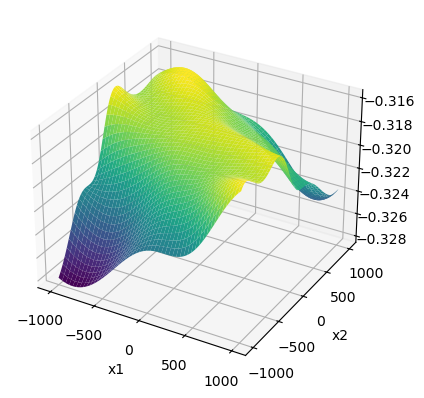

In [37]:
# i want to view the response surface orver x1 and x2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
x1_range = np.linspace(-1000, 1000, 200)
x2_range = np.linspace(-1000, 1000, 200)
X1, X2 = np.meshgrid(x1_range, x2_range)
X = np.hstack((X1.reshape(-1, 1), X2.reshape(-1, 1)))
X_scaled = (X - x_min) / (x_max - x_min)
X_scaled_tensor = torch.tensor(X_scaled, dtype=torch.float32)
with torch.no_grad():
    Z = model(X_scaled_tensor).numpy().reshape(X1.shape)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1, X2, Z, cmap='viridis')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
